## NLP: Natural Language Processing
### Analise de sentimentos

<img src="https://miro.medium.com/max/960/0*xLRsbQ02J7sQpNNy" width=400 height=400/>

### Imports

In [1]:
import pandas as pd
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
from random import sample
from numpy import array
from numpy import asarray
from numpy import zeros
import tensorflow as tf
import re
import nltk
from sklearn.metrics import accuracy_score
from keras.models import load_model
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from tensorflow import keras
import kerastuner as kt
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, GlobalMaxPooling1D, LSTM, SimpleRNN, SpatialDropout1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures
#from kerastuner.tuners import BayesianOptimization
#nltk.download('stopwords')

Using TensorFlow backend.
<ipython-input-1-918218091cb8>:27: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  import kerastuner as kt


### Métodos

In [2]:
TAG_RE = re.compile(r'<[^>]+>')
list_stop_words = set(stopwords.words('english'))
    
# plot resultados
def plot_results(history):
    # acuracia
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()

    # loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train','test'], loc='upper left')
    plt.show()


# pre-processamento
def preprocess_text(sen):
    
    # Removing html tags
    sentence = TAG_RE.sub('', sen)

    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    
    # lowercase
    sentence = sentence.lower()
    
    # remove stopwords
    #sentence = [w for w in sentence if w not in list_stop_words]

    return sentence

### Dataset

In [3]:
movie_reviews = pd.read_csv("data/IMDB Dataset.csv")
print (movie_reviews.isnull().values.any())
print (movie_reviews.shape)

# amostra
movie_reviews, _ = train_test_split(movie_reviews, train_size=0.5, random_state=42, stratify=movie_reviews['sentiment'])
print (movie_reviews.shape)
movie_reviews.head()

False
(50000, 2)
(25000, 2)


,review,sentiment
3055,Trio's vignettes were insightful and quite enj...,positive
47326,I had never heard of this one before the owner...,negative
48869,This is an excellent but hard to find trippy W...,positive
48623,"I am a huge fan of big, loud, trashy, complete...",positive
39657,"Easily Lucio Fulci's most respected film, ""Don...",positive


### Analises

negative    12500
positive    12500
Name: sentiment, dtype: int64


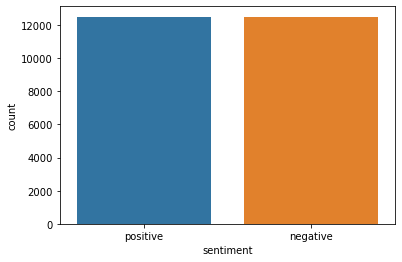

In [4]:
print (movie_reviews['sentiment'].value_counts(dropna=False))
sns.countplot(x='sentiment', data=movie_reviews)

### Pre-processamento

In [5]:
X = []
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess_text(sen))
    
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

### Separa dados em treino e teste

In [6]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
X_val_tmp, X_test_tmp, y_val_tmp, y_test_tmp = train_test_split(X_test, y_test, test_size=0.20, random_state=42)

### Tokenizer

In [7]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)
X_val_tmp = tokenizer.texts_to_sequences(X_val_tmp)
X_test_tmp = tokenizer.texts_to_sequences(X_test_tmp)

# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1
maxlen = 100

X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)
X_val_tmp = pad_sequences(X_val_tmp, padding='post', maxlen=maxlen)
X_test_tmp = pad_sequences(X_test_tmp, padding='post', maxlen=maxlen)

## Modelos com Bag of Words

### Bag of Words

<img src="https://i.ibb.co/j5Dj80T/bad.png" width=400 height=400/>

In [ ]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
CountVec = CountVectorizer(ngram_range=(1,1), stop_words='english')

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### BoW (Bag of Words) + Logistic Regression

In [ ]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

# score medio
y_pred = classifier.predict_proba(df_train_str)[:, 1]

### Score test

In [ ]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)   
        instance = ' '.join([str(x) for x in instance])
        
        #transform test
        instance = CountVec.transform([instance])

        #create dataframe
        instance=pd.DataFrame(instance.toarray(), columns=CountVec.get_feature_names())

        score = classifier.predict_proba(instance)[:, 1][0]
        print (score)
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']
# score list
score_list(list_instances)

### BoW (Bag of Words) + Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### BoW (Bag of Words) + Random Forest

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

## Modelos com tf-idf

<img src="https://miro.medium.com/max/1000/1*KZrjbKHcsWt-zzUj2oRk3w.jpeg" width=400 height=400/>

<img src="https://i.ytimg.com/vi/vZAXpvHhQow/maxresdefault.jpg" width=600 height=60/>

In [ ]:
X_train_str = []
for lista in X_train:
    lista = ' '.join([str(x) for x in lista])
    X_train_str.append(lista)
    
X_test_str = []
for lista in X_test:
    lista = ' '.join([str(x) for x in lista])
    X_test_str.append(lista)
    
vectorizer = TfidfVectorizer()

#transform train
Count_data_train = CountVec.fit_transform(X_train_str)
 
#create dataframe
df_train_str=pd.DataFrame(Count_data_train.toarray(), columns=CountVec.get_feature_names())


#transform test
Count_data_test = CountVec.transform(X_test_str)
 
#create dataframe
df_test_str=pd.DataFrame(Count_data_test.toarray(), columns=CountVec.get_feature_names())

### Tf-Idf (Bag of Words) + Logistic Regression

In [ ]:
classifier = LogisticRegression(solver='lbfgs', max_iter=1000)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Decision Tree

In [ ]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Random Forest (max_depth=3)

In [ ]:
classifier = RandomForestClassifier(max_depth=3)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Random Forest (max_depth=5)

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Random Forest (max_depth=7)

In [ ]:
classifier = RandomForestClassifier(max_depth=7)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Tf-Idf (Bag of Words) + Random Forest (max_depth=15)

In [ ]:
classifier = RandomForestClassifier(max_depth=15)
classifier.fit(df_train_str, y_train)
score_train = round(classifier.score(df_train_str, y_train), 4)
score_test = round(classifier.score(df_test_str, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

## Modelos com Embedding

### Regressão Logística

In [ ]:
classifier = LogisticRegression()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Naive Bayes

In [ ]:
classifier = GaussianNB()
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Árvore de Decisão

In [ ]:
classifier = DecisionTreeClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Random Forest

In [ ]:
classifier = RandomForestClassifier(max_depth=5)
classifier.fit(X_train, y_train)
score_train = round(classifier.score(X_train, y_train), 4)
score_test = round(classifier.score(X_test, y_test), 4)

# results
print("Train Accuracy:", score_train)
print("Test Accuracy:", score_test)

### Modelo simples com Redes Neurais v1 (sem Early Stopping)

In [ ]:
model = Sequential()
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Modelo simples com Redes Neurais  (Early Stopping)

In [ ]:
model = Sequential()
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, validation_data=(X_val_tmp, y_val_tmp), batch_size=128, epochs=30, verbose=1, callbacks=[es, mc])
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Embedding layer (sem Glove)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, input_length=maxlen)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_acc', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Glove

In [ ]:
embeddings_dictionary = dict()
glove_file = open('data/glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions
glove_file.close()

embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

### Simple Model Glove (sem Early Stopping)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=20, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### Simple Model Glove (com Early Stopping)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### CNN Early Stopping

In [ ]:
model = Sequential()

embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)

model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### RNN

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(SimpleRNN(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=5, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=30, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

history = model.fit(X_train, y_train, batch_size=128, epochs=15, verbose=1, validation_split=0.2)
print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

In [ ]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
model.add(embedding_layer)
model.add(LSTM(128, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
print(model.summary())

es = EarlyStopping(monitor='val_loss', mode='min', patience=10, verbose=1)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', verbose=1, save_best_only=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=100, verbose=1, callbacks=[es, mc], validation_split=0.2)
print(model.summary())

# load a saved model (best model)
model = load_model('best_model.h5')
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)

### LSTM com Bayesian Optimizer

In [ ]:
'''
n_epochs = 10

def build_model(hp):
    model = Sequential()
    embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen, trainable=False)
    model.add(embedding_layer)

    model.add(LSTM(units=hp.Int('units1',
                                min_value=30,
                                max_value=100,
                                step=20),
              
                                dropout=hp.Float('dropout',
                                min_value=0.1,
                                max_value=0.3,
                                step=0.1),
    
                                recurrent_dropout=hp.Float('recurrent_dropout',
                                min_value=0.3,
                                max_value=0.6,
                                step=0.1), activation='relu'))
    
    model.add(Dense(units=hp.Int('units2',
                                 min_value=30,
                                 max_value=100,
                                 step=20),
                                 activation='relu'))
    
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  metrics=['acc'],
                  optimizer=keras.optimizers.Adam(
                  hp.Choice('learning_rate',
                  values=[1e-2, 1e-3, 1e-4])))

    return model

bayesian_opt_tuner = BayesianOptimization(
    build_model,
    objective='acc',
    max_trials=20,
    executions_per_trial=1,
    overwrite=True)

bayesian_opt_tuner.search(X_train, y_train, epochs=n_epochs, validation_split=0.2, verbose=1)

bayes_opt_model_best_model = bayesian_opt_tuner.get_best_models(num_models=1)
model = bayes_opt_model_best_model[0]

history = model.fit(X_train, y_train, batch_size=128, validation_split=0.2, epochs=40, verbose=1)

print(model.summary())
score_train = model.evaluate(X_train, y_train, verbose=1)
score_test = model.evaluate(X_test, y_test, verbose=1)

# results
print ("Train Accuracy:", score_train[1])
print("Test Accuracy:", score_test[1])
plot_results(history)
'''

### Prediction (sample)

In [ ]:
instance = sample(X, 1)
print (instance)
instance = tokenizer.texts_to_sequences(instance)

instance = pad_sequences(instance, padding='post', maxlen=maxlen)
print (instance)

score = model.predict(instance)[0][0]
print (score)
if (score >= 0.5):
    print ('Positivo')
else:
    print ('Negativo')

### Prediction (tests)

In [ ]:
def score_list(list_instances):
    
    list_scores = []
    
    for text in list_instances:
        instance = tokenizer.texts_to_sequences([text])
        instance = pad_sequences(instance, padding='post', maxlen=maxlen)

        score = model.predict(instance)[0][0]
        
        if (score >= 0.5):
            flag = 'Positivo'
        else:
            flag = 'Negativo'
            
        list_scores.append([text, score, flag])
        
    df = pd.DataFrame(list_scores, columns=['text', 'score', 'rating'])
    display(df)
        
        
list_instances = ['The movie was amazing, I loved it, very good',
                  'I hate this movie, it is very bad and terrible']

# score list
score_list(list_instances)

### Bert

In [24]:
# treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

#### Bert model

In [33]:
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased")
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [34]:
def convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN): 
    train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                      text_a = x[DATA_COLUMN], 
                                      text_b = None,
                                      label = x[LABEL_COLUMN]), axis = 1)

    validation_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                      text_a = x[DATA_COLUMN], 
                                      text_b = None,
                                      label = x[LABEL_COLUMN]), axis = 1)

    return train_InputExamples, validation_InputExamples
    
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding=True, # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
        input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )

In [35]:
train = pd.DataFrame({'sentiment':X_train, 'review':y_train})
test = pd.DataFrame({'sentiment':X_test, 'review':y_test})

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.shuffle(100).batch(32).repeat(2)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

C:\Users\yanvs\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2184: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [36]:
DATA_COLUMN = 'sentiment'
LABEL_COLUMN = 'review'

train_InputExamples, validation_InputExamples = convert_data_to_examples(train, 
                                                                         test, 
                                                                         DATA_COLUMN, 
                                                                         LABEL_COLUMN)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0), 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('accuracy')])

model.fit(train_data, epochs=2, validation_data=validation_data)

Epoch 1/2
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
      6/Unknown - 630s 105s/step - loss: 0.6843 - accuracy: 0.6042

In [ ]:
pred_sentences = ['This was an awesome movie. I watch it twice my time watching this beautiful movie if I have known it was this good',
                  'One of the worst movies of all time. I cannot believe I wasted two hours of my life for this movie']

In [ ]:
tf_batch = tokenizer(pred_sentences, max_length=128, padding=True, truncation=True, return_tensors='tf')
tf_outputs = model(tf_batch)
tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
labels = ['Negative','Positive']
label = tf.argmax(tf_predictions, axis=1)
label = label.numpy()
for i in range(len(pred_sentences)):
    print(pred_sentences[i], ": \n", labels[label[i]])